# Example 6: Fault evolution
This example describes how to visualize the evolution of faults

## Setup

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/fault_analysis_toolbox/blob/master/examples/6-evolution/6-evolution.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
6. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.

## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install it:

In [5]:
!pip3 install git+https://github.com/thilowrona/fatbox.git

  Cloning https://github.com/thilowrona/fatbox.git to /tmp/pip-req-build-n5lqx7v6
  Running command git clone -q https://github.com/thilowrona/fatbox.git /tmp/pip-req-build-n5lqx7v6
     |████████████████████████████████| 163kB 23.1MB/s 
  Created wheel for fatbox: filename=fatbox-0.0.1-cp37-none-any.whl size=22485 sha256=9b691b69b9e0276ff07a341679d2342e4bc1474dd554ed5e3a98afd85a13804a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ijp024hh/wheels/3c/75/06/4f57a6a85e140ffdf1280b29ebde7d5e62277dfc68e4aeb466
  Created wheel for network: filename=network-0.1-cp37-none-any.whl size=3157 sha256=a25eb2d347ecf659dd007e7cc6019fe983a97ce85e380d9f6f09b341f931500c
  Stored in directory: /root/.cache/pip/wheels/f6/e7/6a/70989d7246573ac455e33b059ed204518c33e9c276965f005f
Successfully built fatbox network


and download the tutorials:

In [6]:
!git clone https://github.com/thilowrona/fatbox_tutorials

Cloning into 'fatbox_tutorials'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 262 (delta 19), reused 0 (delta 0), pack-reused 171
Receiving objects: 100% (262/262), 27.98 MiB | 25.17 MiB/s, done.
Resolving deltas: 100% (90/90), done.


Now we can load the python packages:

In [75]:
import numpy as np 
import networkx as nx
import pickle

import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

from sys import stdout

from fatbox.metrics import get_fault_labels, get_fault, total_length, max_value_nodes
from fatbox.plots import get_node_colors, plot_faults, plot_width
from fatbox.utils import get_colors

and the functions from the fault analysis toolbox that we want to use:

## Load and plot faults

First, we load our fault networks extracted from a 2-D model over several timesteps:

In [35]:
Gs = []
for n in range(3,50):
  Gs.append(pickle.load(open('/content/fatbox_tutorials/6-evolution/graphs/g_'+ str(n) + '.p', 'rb')))

Now we can visualize these faults:

In [36]:
%matplotlib inline
from ipywidgets import interactive, widgets, Layout


def f(time):
    fig, ax = plt.subplots(figsize=(16,4))
    plot_faults(Gs[time], ax, label=False)
    plt.xlim([1000, 3500])
    plt.ylim([600, 0])
    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=3, max=49, step=1, layout=Layout(width='900px')))
output = interactive_plot.children[-1]
output.layout.width = '1000px'
interactive_plot

interactive(children=(IntSlider(value=3, description='time', layout=Layout(width='900px'), max=49, min=3), Out…

Note that you use the arrow keys to play the time forward and backward.

## Plots through time
One of the easiest ways to follow the evolution of our faults is to track them through time. All we need to do is:

1.   Loop through time
2.   Get fault labels
3.   Visualize them



In [37]:
max_comp = 45

faults      = np.zeros((max_comp,len(Gs)))
faults[:,:] = np.nan

for time in range(len(Gs)):
    G = Gs[time]
    labels = get_fault_labels(G)
    number_of_faults = len(labels)
    for n, label in enumerate(labels):
      fault = get_fault(G, label)
      faults[n, time]  = label

To visualize them, we can use these nice bar plots:

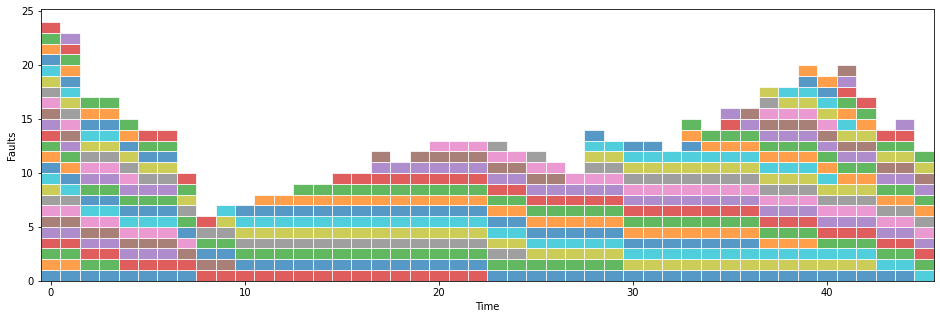

In [38]:
def bar_plot(attribute, faults, times, steps=[], ax=[]):

    colors = get_colors() 
        
    if ax==[]:
        fig, ax = plt.subplots()  

    if steps==[]:
        steps = range(attribute.shape[1])
    
    for n, step in enumerate(steps):
        bottom = 0
        for m, fault in enumerate(faults[:, step]):
            if np.isfinite(fault):
                a=attribute[m,step]
                ax.bar(n, a, 1, bottom=bottom, alpha=0.75, edgecolor='white', color=colors[int(fault),:])
                bottom += a
            else:
                break



steps = range(len(Gs))

fig, ax = plt.subplots(figsize=(16,5))
bar_plot(np.ones_like(faults), faults, len(Gs), steps, ax)
ax.set_xlim([-0.5, 45.5])
ax.set_xlabel('Time')
ax.set_ylabel('Faults')
plt.show()

Here we can see the fault labels as colors as well as the number of faults as histogram, but the plot doesn't capture the fault size.

So let's add the fault length and displacement to the mix. First, we need to track these attributes through time:

In [40]:
max_comp = 45

faults      = np.zeros((max_comp,len(Gs)))
faults[:,:] = np.nan

lengths         = np.zeros((max_comp,len(Gs)))
lengths[:,:]    = np.nan

displacements         = np.zeros((max_comp,len(Gs)))
displacements[:,:]    = np.nan

for time in range(len(Gs)):    
    
    G = Gs[time]
    
    labels           = get_fault_labels(G)
    number_of_faults = len(labels)

    for n, label in enumerate(labels):

      fault = get_fault(G, label)

      faults[n, time]  = label    
      lengths[n, time] = total_length(fault)
      displacements[n, time] = max_value_nodes(fault, 'displacement')

    lengths[:,time] = np.sort(lengths[:,time])
    displacements[:,time] = np.sort(displacements[:,time])


Now we can plot 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Saw kwargs ['fc', 'facecolor'] which are all aliases for 'facecolor'.  Kept value from 'facecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.


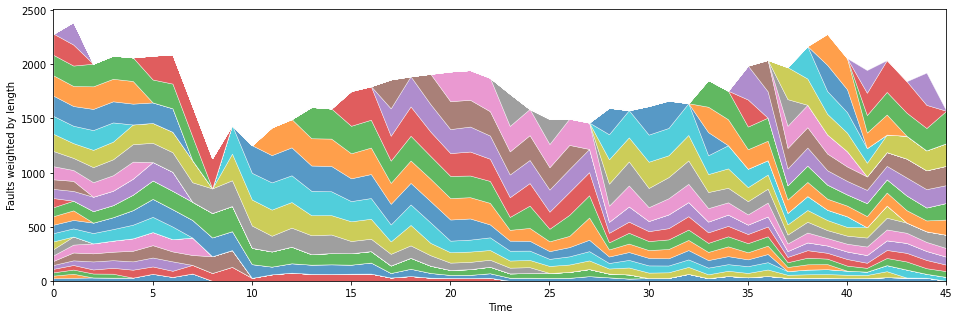

In [41]:

def stack_plot(attribute, faults, times, steps=[], ax=[]):
    
    colors = get_colors()
    
    if ax==[]:
        fig, ax = plt.subplots()  

    if steps==[]:
        steps = range(attribute.shape[1])   
    
    max_fault = int(np.nanmax(faults))

    x = np.arange(len(steps))
    y = np.zeros((max_fault, len(steps)))
        
    for N in range(max_fault):
        for n in steps:
            row = faults[:,n]
            if N in faults[:,n]:
                index = np.where(row==N)[0][0]
                y[N,n] = attribute[index,n]
            
    ax.stackplot(x, y, fc=colors[:max_fault,:], alpha=0.75, edgecolor='white', linewidth=0.5)
    

fig, ax = plt.subplots(figsize=(16,5))
stack_plot(lengths, faults, len(Gs), steps, ax)
ax.set_xlim([0, 45])
ax.set_xlabel('Time')
ax.set_ylabel('Faults weighted by length')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Saw kwargs ['fc', 'facecolor'] which are all aliases for 'facecolor'.  Kept value from 'facecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.


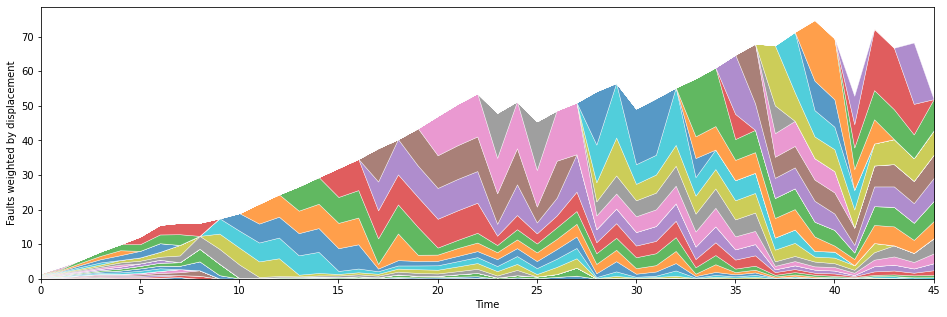

In [42]:
fig, ax = plt.subplots(figsize=(16,5))
stack_plot(displacements/1000, faults, len(Gs), steps, ax)
ax.set_xlim([0, 45])
ax.set_xlabel('Time')
ax.set_ylabel('Faults weighted by displacement')
plt.show()

This is great! We can summarize the evolution of the entire fault system in one plot, but what we don't see is how individual faults grow. We know they consist of multiple segments (components), which merge and split up with time. How could we keep track of these processes?

## A graph of graphs
The basic idea is that we define another graph, which captures the evolution of the fault network through time. Let's start from here again:

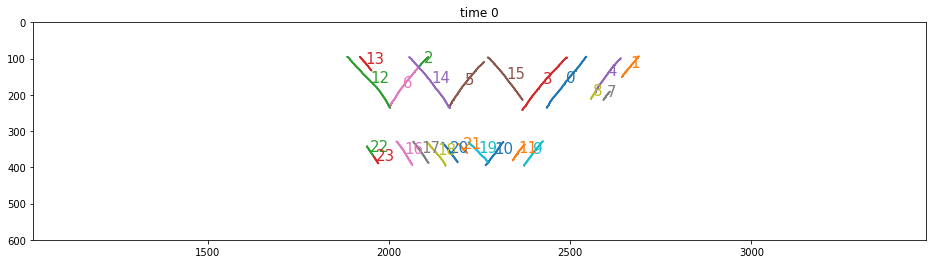

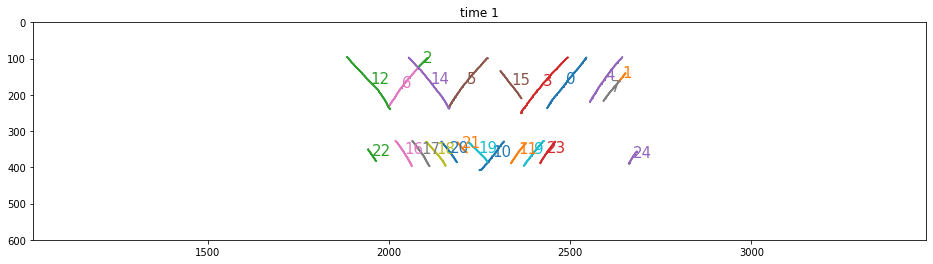

In [43]:
time = 0

G_0 = Gs[time]
G_1 = Gs[time+1]

fig, ax = plt.subplots(figsize=(16,4))
plot_faults(G_0, ax, label=True)
plt.title('time 0')
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

fig, ax = plt.subplots(figsize=(16,4))
plt.title('time 1')
plot_faults(G_1, ax, label=True)
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

Let's set up a graph (H), where each node corresponds to a fault at a particular time:

In [51]:
H = nx.Graph()

def H_add_nodes(H, G, time):  
    labels = get_fault_labels(G)
    for label in labels:
        H.add_node((time, label))
        H.nodes[(time, label)]['pos'] = (time, label)
        H.nodes[(time, label)]['time'] = time
        H.nodes[(time, label)]['fault'] = label  
    return H

time = 0

G_0 = Gs[time]
G_1 = Gs[time+1]

H = H_add_nodes(H, G_0, 0)
H = H_add_nodes(H, G_1, 1)

Let's look at this graph:

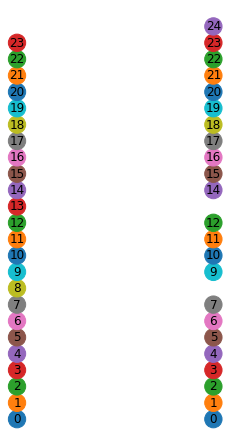

In [52]:
plt.figure(figsize=(3,6))
nx.draw(H,
        pos = nx.get_node_attributes(H, 'pos'),
        labels=nx.get_node_attributes(H, 'fault'),
        with_labels=True,
        node_color = get_node_colors(H, 'fault'))

and now let's add connections:

In [53]:
for label_0 in get_fault_labels(G_0):
    for label_1 in get_fault_labels(G_1):
        if label_0 == label_1:
            H.add_edge((time, label_0), (time+1, label_1))

and plot it:

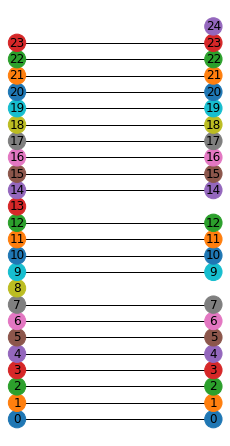

In [54]:
plt.figure(figsize=(3,6))
nx.draw(H,
        pos = nx.get_node_attributes(H, 'pos'),
        labels=nx.get_node_attributes(H, 'fault'),
        with_labels=True,
        node_color = get_node_colors(H, 'fault'))

Awesome! Let's do this for all time steps:

In [58]:
H = nx.Graph()

def H_add_nodes(H, G, time):  
    labels = get_fault_labels(G)
    for label in labels:
        H.add_node((time, label))
        H.nodes[(time, label)]['pos'] = (time, label)
        H.nodes[(time, label)]['time'] = time
        H.nodes[(time, label)]['fault'] = label

        fault = get_fault(G, label)
        H.nodes[(time, label)]['length'] = total_length(fault)
        H.nodes[(time, label)]['displacement'] = max_value_nodes(fault, 'displacement') 
    return H



for time in range(0, len(Gs)-1):

  print(time)

  G_0 = Gs[time]
  G_1 = Gs[time+1]

  if time == 0:
    H = H_add_nodes(H, G_0, time)  
  H = H_add_nodes(H, G_1, time+1) 


  for label_0 in get_fault_labels(G_0):
      for label_1 in get_fault_labels(G_1):
          if label_0 == label_1:
              H.add_edge((time, label_0), (time+1, label_1))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


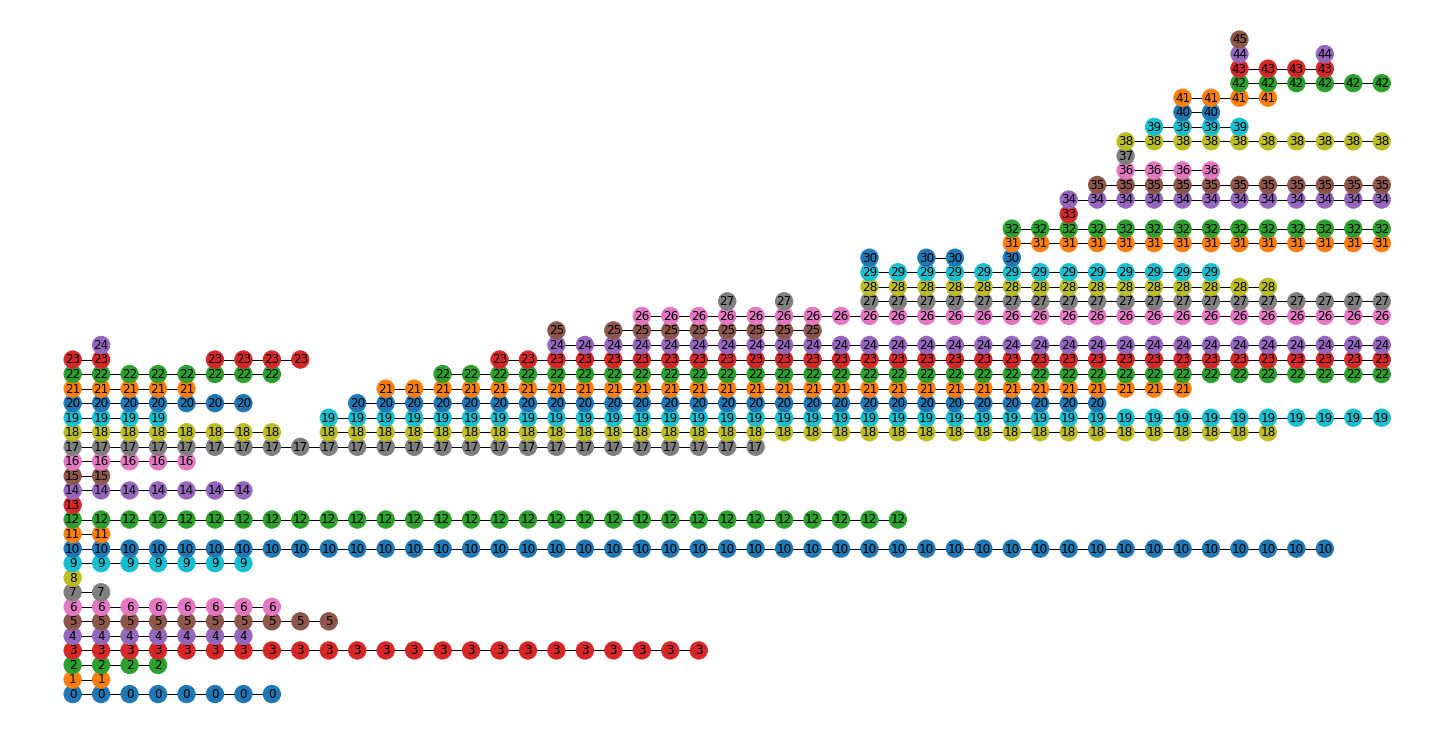

In [59]:
plt.figure(figsize=(20,10))
nx.draw(H,
        pos = nx.get_node_attributes(H, 'pos'),
        labels=nx.get_node_attributes(H, 'fault'),
        with_labels=True,
        node_color = get_node_colors(H, 'fault'))

Now let's weigh the node size by displacement:

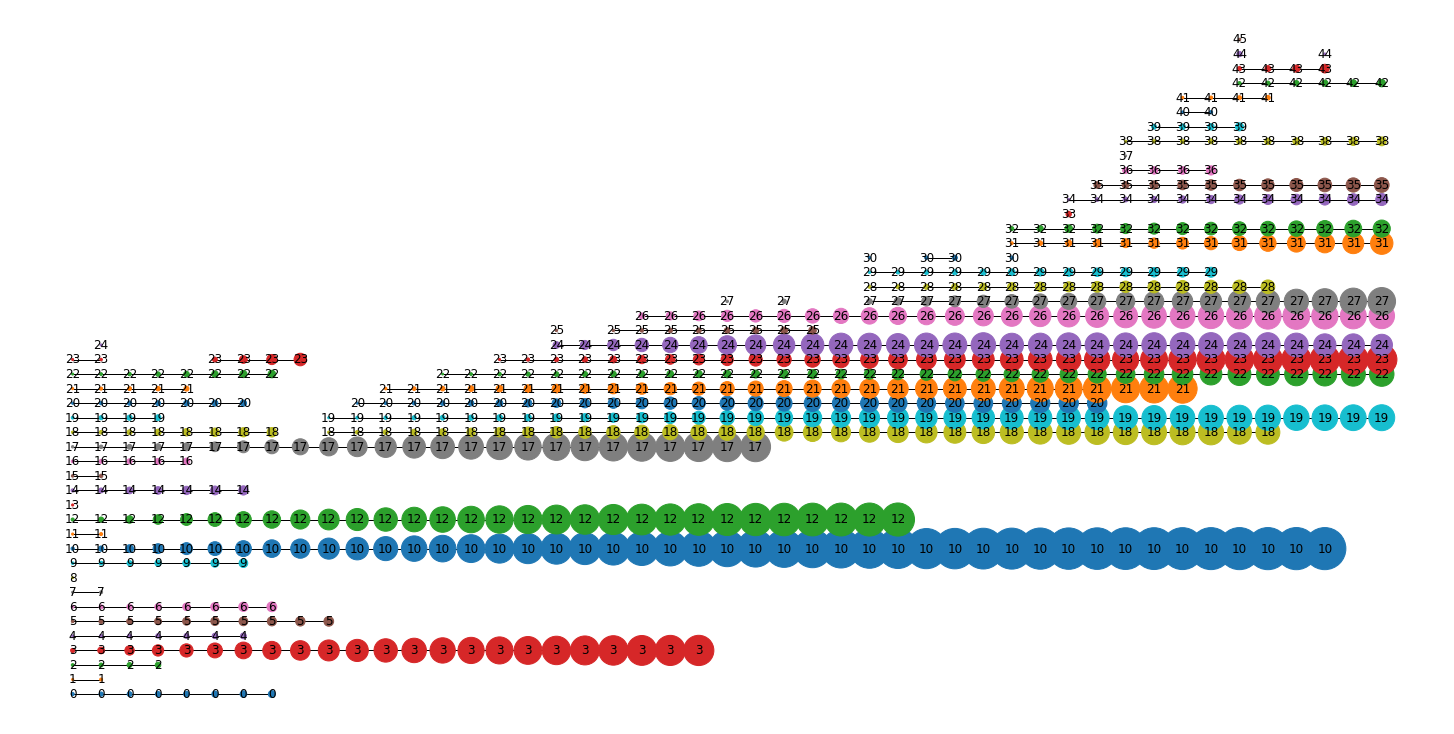

In [73]:
plt.figure(figsize=(20,10))
nx.draw(H,
        pos = nx.get_node_attributes(H, 'pos'),
        labels=nx.get_node_attributes(H, 'fault'),
        with_labels=True,
        node_color = get_node_colors(H, 'fault'),
        node_size = [H.nodes[node]['displacement']*0.1 for node in H])

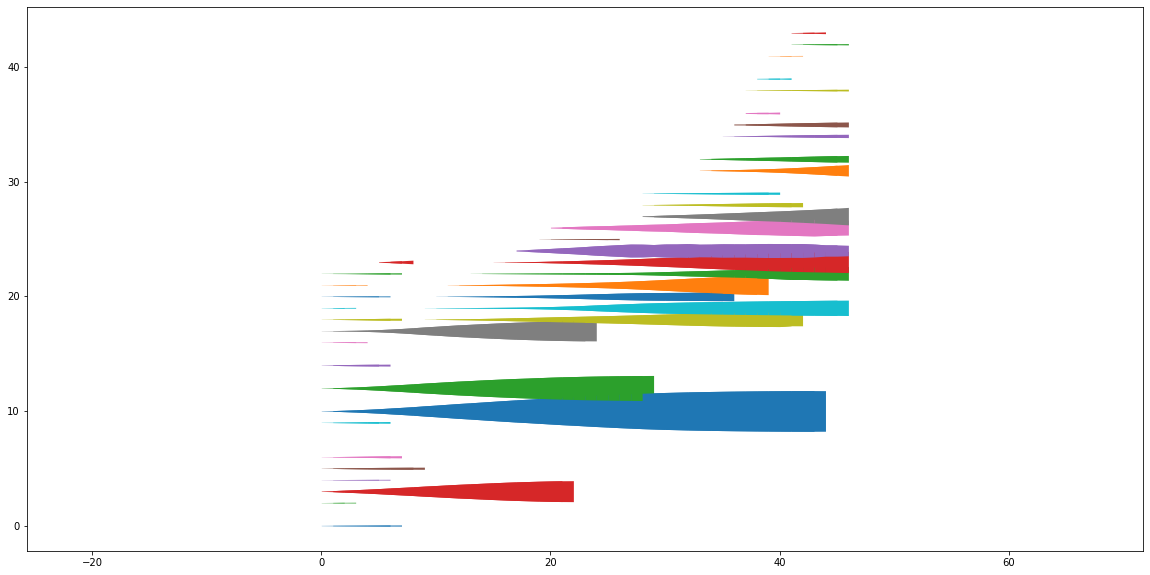

In [87]:
attribute = 'displacement'
factor= 0.0001
width = dict(zip([node for node in H], [H.nodes[node]['displacement']*factor for node in H]))

fig, ax = plt.subplots(figsize=(20,10))
plot_width(H, ax, width, tips=False)
plt.show()

Alright we can see how faults evolve, but not how they merge and split up.

So let's set up a graph (H), where each node corresponds to a fault segment (component) at a particular time. Moreover, we populate these nodes with some basic properties:

In [101]:
H = nx.Graph()

def H_add_nodes(H, G, time):
  
    for cc in sorted(nx.connected_components(G)):
        for node in cc:
            label = G.nodes[node]['component']
            H.add_node((time, label))
            
            H.nodes[(time, label)]['pos'] = (time, label)
            H.nodes[(time, label)]['time'] = time
            H.nodes[(time, label)]['fault'] = G.nodes[node]['fault']
            H.nodes[(time, label)]['component'] = G.nodes[node]['component']
        
            break
    
        G_cc = nx.subgraph(G, cc)
        
        H.nodes[(time, label)]['length'] = total_length(G_cc)
        H.nodes[(time, label)]['displacement'] = max_value_nodes(G_cc, 'displacement')
        
    return H 

time = 0

G_0 = Gs[time]
G_1 = Gs[time+1]

H = H_add_nodes(H, G_0, 0)
H = H_add_nodes(H, G_1, 1)

Let's look at H:

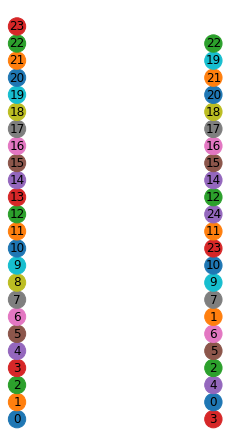

In [102]:
plt.figure(figsize=(3,6))
nx.draw(H,
        pos = nx.get_node_attributes(H, 'pos'),
        labels=nx.get_node_attributes(H, 'fault'),
        with_labels=True,
        node_color = get_node_colors(H, 'fault'))

Alright, just some nodes corresponding to the components at time 0 and 1 labelled by the fault that they belong to.

Now let's connect the components which belong to the same fault, i.e. have the same label in the above plot. For this purpose, we create a dictionary of the components belonging to each fault:

In [103]:
def get_dictionary(G):
    faults = get_fault_labels(G)        
    dic = {}
    for fault in faults:
        G_fault = get_fault(G, fault)
        components = set()
        for node in G_fault:
            components.add(G_fault.nodes[node]['component'])
        dic[fault] = sorted(list(components))
    return dic


dic_0 = get_dictionary(G_0)
dic_1 = get_dictionary(G_1)

print(dic_0)

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 17: [17], 18: [18], 19: [19], 20: [20], 21: [21], 22: [22], 23: [23]}


Now we compute the faults common between consecutive time steps:

In [104]:
faults_0 = get_fault_labels(G_0)
faults_1 = get_fault_labels(G_1)

common_faults = list(set(faults_0).intersection(set(faults_1)))

Next we loop through the common faults, get the components for time 0 (starts) and time 1 (ends) and connect the components. This is a bit complicated because we can have different numbers of components, e.g. sometimes the fault has only one component at time 0 (len(starts)==1) and one at time 1 (len(ends)==1), then we can simply add an edge, but if there are multiple components to each fault, we need add multiple edges:

In [105]:
for fault in common_faults:
    starts = dic_0[fault]
    ends   = dic_1[fault]
    if len(starts) == 1 and len(ends) == 1:
        H.add_edge((time, starts[0]), (time+1, ends[0]))
    elif len(starts) == 1 and len(ends) > 1:
        for end in ends:
            H.add_edge((time, starts[0]), (time+1, end))
    elif len(starts) > 1 and len(ends) == 1:
          for start in starts:
            H.add_edge((time, start), (time+1, ends[0]))
    elif len(starts) > 1 and len(ends) > 1:
        if len(starts) == len(ends):
            for start, end in zip(starts, ends):
                H.add_edge((time, start), (time+1, end))
        elif len(starts) < len(ends):
            minimum = min(len(starts), len(ends))
            difference = len(ends)-len(starts)
            for n in range(minimum):
                H.add_edge((time, starts[n]), (time+1, ends[n]))
            for n in range(difference):
                H.add_edge((time, starts[minimum-1]), (time+1, ends[minimum-1+n+1]))
        elif len(starts) > len(ends):
            minimum = min(len(starts), len(ends))
            difference = len(starts)-len(ends)                
            for n in range(minimum):
                H.add_edge((time, starts[n]), (time+1, ends[n]))                
            for n in range(difference):
                H.add_edge((time, starts[minimum-1+n+1]), (time+1, ends[minimum-1])) 

Now let's look at the result:

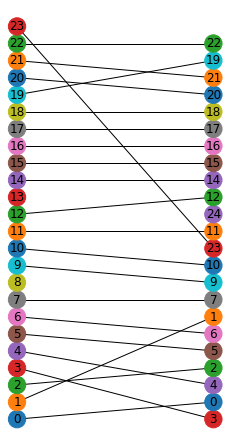

In [106]:
plt.figure(figsize=(3,6))
nx.draw(H,
        pos = nx.get_node_attributes(H, 'pos'),
        labels=nx.get_node_attributes(H, 'fault'),
        with_labels=True,
        node_color = get_node_colors(H, 'fault'))

In [107]:
H.nodes

NodeView(((0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22)))

Excellent! Let's do this for all time steps:

In [108]:
H = nx.Graph()

for time in range(0, len(Gs)-1):

  print(time)

  G_0 = Gs[time]
  G_1 = Gs[time+1]

  if time == 0:
    H = H_add_nodes(H, G_0, time)  
  H = H_add_nodes(H, G_1, time+1)  

  faults_0 = get_fault_labels(G_0)
  faults_1 = get_fault_labels(G_1) 

  dic_0 = get_dictionary(G_0)
  dic_1 = get_dictionary(G_1)
          
  
  faults = list(set(faults_0).intersection(set(faults_1)))


  for fault in faults:
      starts = dic_0[fault]
      ends   = dic_1[fault]
      if len(starts) == 1 and len(ends) == 1:
          H.add_edge((time, starts[0]), (time+1, ends[0]))
      elif len(starts) == 1 and len(ends) > 1:
          for end in ends:
              H.add_edge((time, starts[0]), (time+1, end))
      elif len(starts) > 1 and len(ends) == 1:
            for start in starts:
              H.add_edge((time, start), (time+1, ends[0]))
      elif len(starts) > 1 and len(ends) > 1:
          if len(starts) == len(ends):
              for start, end in zip(starts, ends):
                  H.add_edge((time, start), (time+1, end))
          elif len(starts) < len(ends):
              minimum = min(len(starts), len(ends))
              difference = len(ends)-len(starts)
              for n in range(minimum):
                  H.add_edge((time, starts[n]), (time+1, ends[n]))
              for n in range(difference):
                  H.add_edge((time, starts[minimum-1]), (time+1, ends[minimum-1+n+1]))
          elif len(starts) > len(ends):
              minimum = min(len(starts), len(ends))
              difference = len(starts)-len(ends)                
              for n in range(minimum):
                  H.add_edge((time, starts[n]), (time+1, ends[n]))                
              for n in range(difference):
                  H.add_edge((time, starts[minimum-1+n+1]), (time+1, ends[minimum-1]))     

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


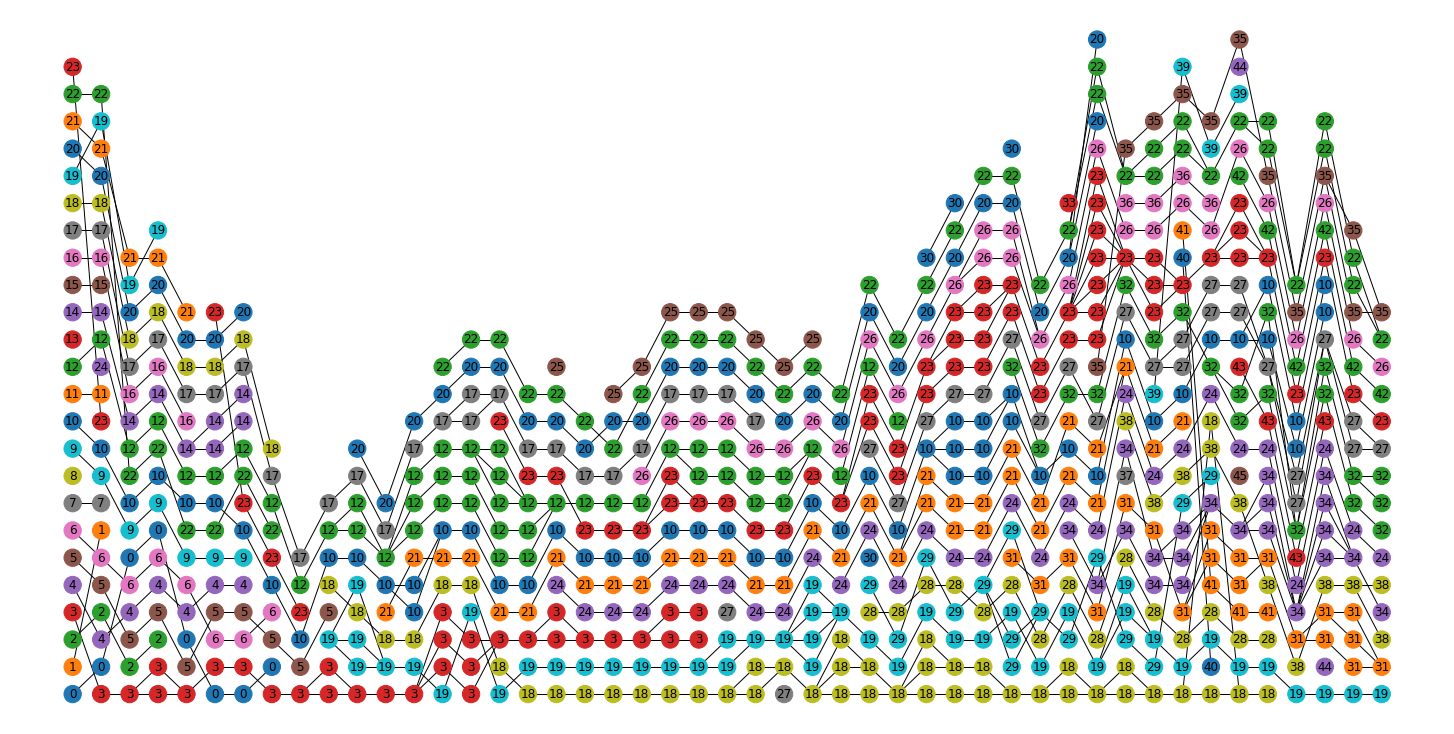

In [110]:
plt.figure(figsize=(20,10))
nx.draw(H,
        pos = nx.get_node_attributes(H, 'pos'),
        labels=nx.get_node_attributes(H, 'fault'),
        with_labels=True,
        node_color = get_node_colors(H, 'fault'))

Now we start to get a grasp of the complexity involved in the evolution of the fault system. Let's just check out one fault:

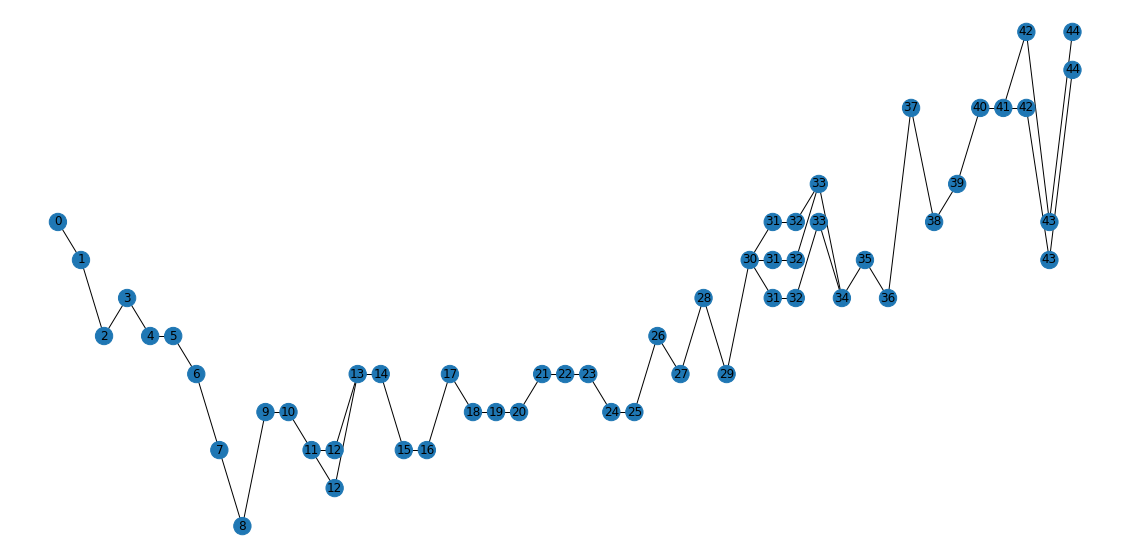

In [112]:
fault = 10

H_sub = nx.subgraph(H, [node for node in H if H.nodes[node]['fault']==fault])

fig, ax = plt.subplots(figsize=(20,10))
nx.draw(H_sub,
        pos = nx.get_node_attributes(H_sub, 'pos'),
        labels=nx.get_node_attributes(H_sub, 'time'),
        with_labels=True,
        node_color = get_node_colors(H_sub, 'fault'),
        ax=ax)
plt.show()

Now we can see how the fault splits in two segments at time 12 and then merges again into one at time 13 and much more...

For example, we can use the H-graph to plot the evolution of fault properties, such as length and displacement through time:

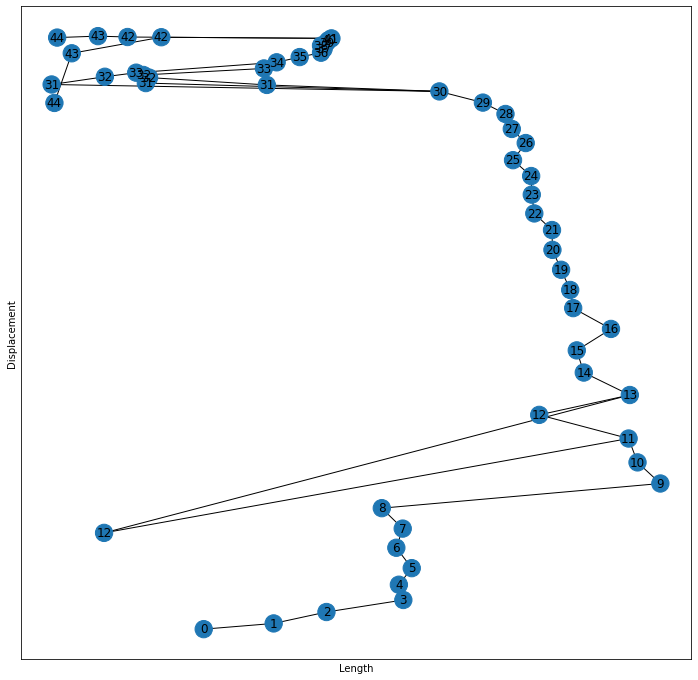

In [113]:
fault = 10
attribute_0 = 'length'
attribute_1 = 'displacement'

H_sub = nx.subgraph(H, [node for node in H if H.nodes[node]['fault']==fault])

fig, ax = plt.subplots(figsize=(12,12))
nx.draw(H_sub,
        pos = dict(zip([node for node in H_sub], [(H_sub.nodes[node][attribute_0], H_sub.nodes[node][attribute_1]) for node in H_sub])),
        labels=nx.get_node_attributes(H_sub, 'time'),
        with_labels=True,
        node_color = get_node_colors(H_sub, 'fault'),
        ax=ax)
ax.set_xlabel('Length')
ax.set_ylabel('Displacement')
ax.axis('on')
plt.show()

We can see how the fault grows sometimes in length and sometimes in displacement, how it captures smaller segements (time 12) and how it dies out (time >30) becoming shorter and shorter.

And we can plot these properties for all faults in the system:

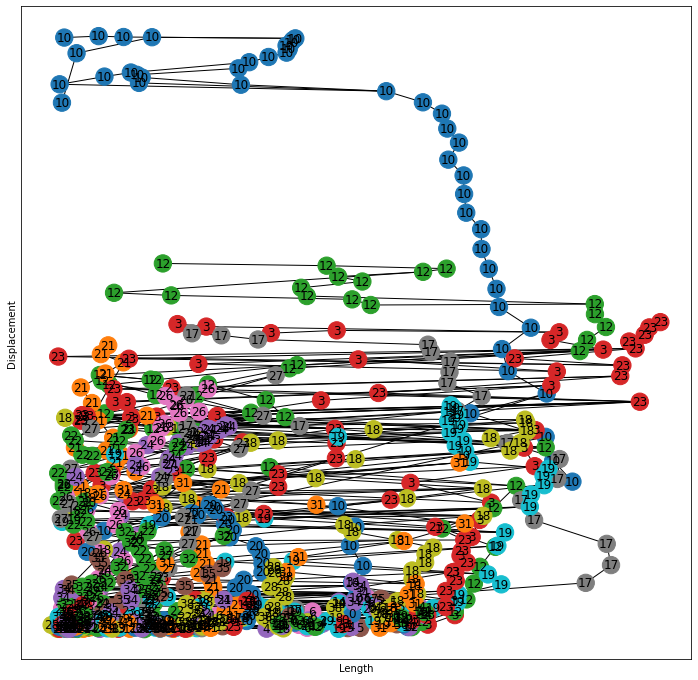

In [114]:
attribute_0 = 'length'
attribute_1 = 'displacement'

fig, ax = plt.subplots(figsize=(12,12))
nx.draw(H,
        pos = dict(zip([node for node in H], [(H.nodes[node][attribute_0], H.nodes[node][attribute_1]) for node in H])),
        labels=nx.get_node_attributes(H, 'fault'),
        with_labels=True,
        node_color = get_node_colors(H, 'fault'),
        ax=ax)
ax.set_xlabel('Length')
ax.set_ylabel('Displacement')
ax.axis('on')
plt.show()

Last, we want to capture these processes in Sankey-type diagram, where the edge width of our graph H shows a fault property, e.g. displacement:

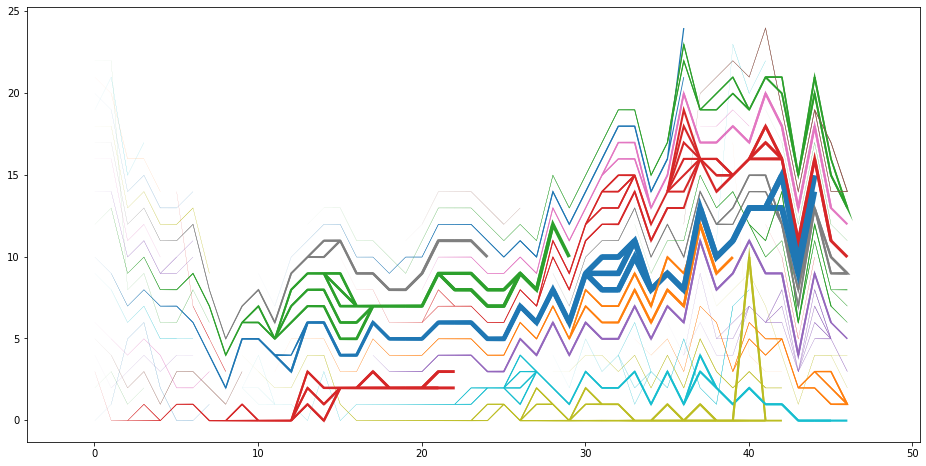

In [115]:
attribute = 'displacement'
factor= 0.00001
width = dict(zip([node for node in H], [H.nodes[node][attribute]*factor for node in H]))

fig, ax = plt.subplots(figsize=(16,8))

plot_width(H, ax, width, tips=False)

Check this out! The long-lived blue line which thickens with time is fault 10, which we can track throughout our model run:

In [116]:
%matplotlib inline
from ipywidgets import interactive, widgets, Layout


def f(time):
    fig, ax = plt.subplots(figsize=(16,4))
    plot_faults(Gs[time], ax, label=True)
    plt.xlim([1000, 3500])
    plt.ylim([600, 0])
    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=3, max=49, step=1, layout=Layout(width='900px')))
output = interactive_plot.children[-1]
output.layout.width = '1000px'
interactive_plot

interactive(children=(IntSlider(value=3, description='time', layout=Layout(width='900px'), max=49, min=3), Out…